## Introduction

### Business Context
The banking industry is very competitive, with many financial products aimed at meeting customer needs. One popular product is the term deposit, where customers invest their money for a fixed time and earn a guaranteed interest. Getting customers to subscribe to term deposits is not easy and needs carefully planned marketing campaigns.

Banks run marketing campaigns to attract customers to subscribe to term deposits. By using past data, machine learning can help predict which customers are more likely to subscribe. This allows banks to focus their efforts on the right customers and use their resources better.

### Problem Statement
Even with marketing campaigns, many customers do not subscribe to term deposits. This leads to a waste of resources and effort. The goal of this project is to predict if a customer will subscribe to a term deposit based on their profile and past interactions. This will help banks improve their marketing efficiency and get better results.

### Goals
- Create a model that predicts if a customer will subscribe to a term deposit.
- Identify which factors are most important for predicting subscription.

### Metric Evaluation
In this project, we will focus on **Precision** as the main metric.

- **Type I Error (False Positive):** This happens when the model predicts that a customer will subscribe, but they do not. This wastes marketing resources and increases costs.
- **Type II Error (False Negative):** This happens when the model predicts that a customer will not subscribe, but they actually do. This means losing potential revenue.

**Why Precision?** Since wasting marketing resources (Type I Error) is more expensive, Precision is the better choice. Precision helps ensure that the customers the model predicts as likely to subscribe are actually the right ones, saving time and money.

### Analytic Approach
- Study the dataset to understand its structure and patterns.
- Prepare and clean the data to make it ready for building the model.
- Create new features to improve the model's predictions.
- Test different models and evaluate them using **Precision** as the main metric.
- Improve the best model by tuning its parameters.
- Find out which factors are most important for predicting if a customer will subscribe.

## Initialization

In [1]:
## Import Libraries

# General
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Data Cleaning
import missingno

# Feature Engineering and Preprocessing
from scipy.stats import skew
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Ignore Warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)



## Exploratory Data Understanding

### Dataset Overview
Let's load the dataset and display basic statistics to understand its structure.


In [2]:
# Load the dataset
file_path = 'data_bank_marketing_campaign.csv'
data = pd.read_csv(file_path)

# Display the first few rows
data.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


### Attributes and Descriptions
| **Attribute** | **Description**                                      |
|---------------|------------------------------------------------------|
| `age`         | Age of the customer.                                |
| `job`         | Job type of the customer.                           |
| `balance`     | Customer's current account balance.                 |
| `housing`     | Whether the customer has a housing loan (yes/no).   |
| `loan`        | Whether the customer has a personal loan (yes/no).  |
| `contact`     | Communication type (e.g., telephone, cellular).     |
| `month`       | Month of the last contact.                          |
| `campaign`    | Number of contacts made during this campaign.       |
| `pdays`       | Days since the last contact in a previous campaign. |
| `poutcome`    | Outcome of the previous campaign (e.g., success).   |
| `deposit`     | Target variable: Subscribed to term deposit (yes/no).|

In [3]:
# Count and Datatype for each Column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


In [4]:
listItem = []
for col in data.columns :
    listItem.append([col, data[col].dtype, data[col].isna().sum(), round((data[col].isna().sum()/len(data[col])) * 100,2),
                    data[col].nunique(), list(data[col].drop_duplicates().head(4).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,75,"[55, 39, 51, 38]"
1,job,object,0,0.0,12,"[admin., self-employed, services, housemaid]"
2,balance,int64,0,0.0,3153,"[1662, -3058, 3025, -87]"
3,housing,object,0,0.0,2,"[no, yes]"
4,loan,object,0,0.0,2,"[no, yes]"
5,contact,object,0,0.0,3,"[cellular, telephone, unknown]"
6,month,object,0,0.0,12,"[jun, apr, may, nov]"
7,campaign,int64,0,0.0,32,"[2, 3, 1, 4]"
8,pdays,int64,0,0.0,422,"[-1, 352, 21, 91]"
9,poutcome,object,0,0.0,4,"[unknown, other, failure, success]"


In [5]:
# Replace all 'unknown' values across all columns with NaN
data.replace('unknown', np.nan, inplace=True)

# Check for missing data after replacement
missing_data = data.isnull().sum()

# Display missing data counts
print(missing_data)


age            0
job           54
balance        0
housing        0
loan           0
contact     1639
month          0
campaign       0
pdays          0
poutcome    5819
deposit        0
dtype: int64


### Class Distribution Check
In this section, we analyze the distribution of the target variable (`deposit`) to check if the dataset is imbalanced..

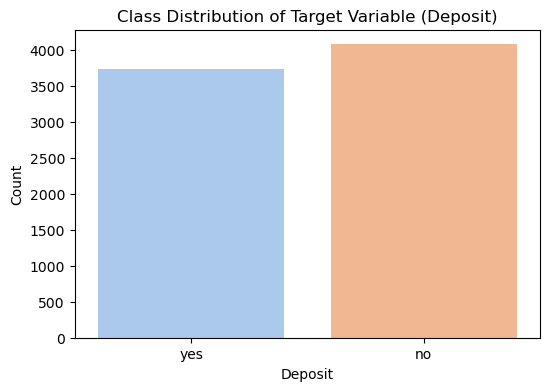

Class Distribution (in %):
deposit
no     52.233457
yes    47.766543
Name: proportion, dtype: float64


In [6]:
# Plot the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='deposit', palette='pastel')
plt.title('Class Distribution of Target Variable (Deposit)')
plt.xlabel('Deposit')
plt.ylabel('Count')
plt.show()

# Display percentages
target_distribution = data['deposit'].value_counts(normalize=True) * 100
print("Class Distribution (in %):")
print(target_distribution)

Data is not imbalanced. No action is required.

## Data Cleaning

### 1. Handling Missing Values

In [7]:
data.isna()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
7808,False,False,False,False,False,False,False,False,False,True,False
7809,False,False,False,False,False,False,False,False,False,False,False
7810,False,True,False,False,False,False,False,False,False,True,False
7811,False,False,False,False,False,False,False,False,False,True,False


In [8]:
# Check for missing values
print("Missing Values Count Before Cleaning:")
print(data.isnull().sum())

Missing Values Count Before Cleaning:
age            0
job           54
balance        0
housing        0
loan           0
contact     1639
month          0
campaign       0
pdays          0
poutcome    5819
deposit        0
dtype: int64


The dataset contains missing values in the following categorical features:
- `job`
- `contact`
- `poutcome`

In [9]:
missing_indicators = data.isnull().astype(int)

# Add the target variable to the missing indicators DataFrame
missing_indicators['deposit'] = data['deposit'].apply(lambda x: 1 if x == 'yes' else 0)  # Ensure deposit is binary

# Compute correlations between missing indicators and the target variable
correlation_with_target = missing_indicators.corr()['deposit'].drop('deposit')

# Display correlations
print("Correlation of Missing Features with Target ('deposit'):")
print(correlation_with_target)
sorted_correlation = correlation_with_target.sort_values(ascending=False)
print("\nSorted Correlation of Missing Features with Target ('deposit'):")
print(sorted_correlation)


Correlation of Missing Features with Target ('deposit'):
age              NaN
job         0.000637
balance          NaN
housing          NaN
loan             NaN
contact    -0.264889
month            NaN
campaign         NaN
pdays            NaN
poutcome   -0.237757
Name: deposit, dtype: float64

Sorted Correlation of Missing Features with Target ('deposit'):
job         0.000637
poutcome   -0.237757
contact    -0.264889
age              NaN
balance          NaN
housing          NaN
loan             NaN
month            NaN
campaign         NaN
pdays            NaN
Name: deposit, dtype: float64


To address the missing values in the dataset, we apply different strategies tailored to each feature's context and importance:

1. **`job` Feature:**
   - Missing values in the `job` column are replaced using the **most frequent (mode)** value. 
   - This ensures the structure of the data remains intact by filling in the most common category, minimizing bias.

2. **`contact` and `poutcome` Features:**
   - Missing values in the `contact` and `poutcome` columns are replaced with placeholder categories: `"unknown_contact"` and `"unknown_outcome"` to preserve the missingness as a potential predictive signal.


In [10]:
categorical_features = ['job', 'contact', 'poutcome']

# Handling missing values for 'job' using the most frequent value
job_imputer = SimpleImputer(strategy='most_frequent')
data['job'] = job_imputer.fit_transform(data[['job']]).ravel()  # Use ravel() to flatten the 2D array

# Handling missing values for 'contact' by replacing with a new category
data['contact'] = data['contact'].fillna('unknown_contact')

# Handling missing values for 'poutcome' using the most frequent value
poutcome_imputer = SimpleImputer(strategy='most_frequent')
data['poutcome'] = poutcome_imputer.fit_transform(data[['poutcome']]).ravel()  # Use ravel() to flatten the 2D array

# Verify
print("Remaining Missing Values After Handling:")
print(data.isnull().sum())


Remaining Missing Values After Handling:
age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64


### 2. Handling Duplicates

In [11]:
# Check for duplicates in the entire dataset
duplicates = data.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 8


In [12]:
# View the actual duplicate rows
duplicate_rows = data[data.duplicated()]
print(duplicate_rows)


      age          job  balance housing loan          contact month  campaign  \
2944   40  blue-collar        0     yes   no  unknown_contact   may         2   
4368   60   management        0      no   no         cellular   aug         3   
4874   41   management        0      no   no         cellular   aug         2   
5326   44  blue-collar        0     yes   no         cellular   jul         1   
5609   39   technician        0     yes   no  unknown_contact   may         1   
5681   38   technician        0      no   no         cellular   aug         2   
5905   34   management        0      no   no         cellular   aug         2   
7077   30  blue-collar      239     yes   no  unknown_contact   may         1   

      pdays poutcome deposit  
2944     -1  failure      no  
4368     -1  failure     yes  
4874     -1  failure      no  
5326     -1  failure      no  
5609     -1  failure      no  
5681     -1  failure      no  
5905     -1  failure      no  
7077     -1  failure  

### 3. Handling Outliers
Calculate skew, identify outliers in numerical features using the IQR method, and  visualize boxplot.


In [13]:
data['campaign'].value_counts()

campaign
1     3354
2     2108
3      922
4      548
5      256
6      196
7      103
8       89
9       47
10      41
11      28
13      23
12      20
14      10
17       9
15       8
16       7
18       7
21       5
20       4
24       4
19       4
30       4
23       3
22       3
25       2
26       2
29       2
63       1
33       1
28       1
43       1
Name: count, dtype: int64

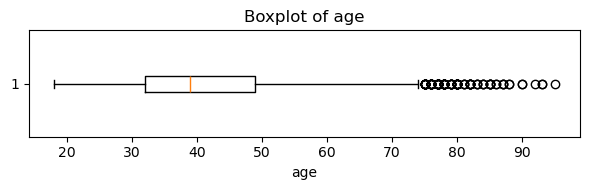

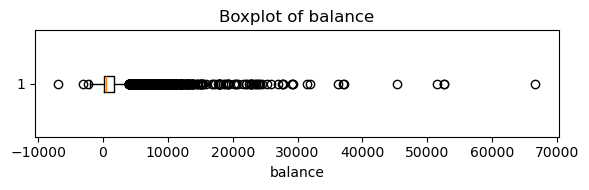

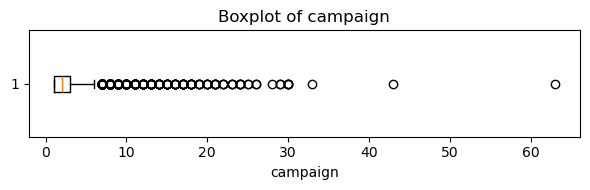

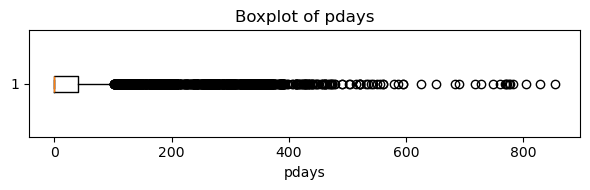

    Feature  Skewness  Outliers Count
0       age  0.867620             121
1   balance  6.760662             736
2  campaign  5.538156             429
3     pdays  2.411313            1454


In [14]:
# List of numerical features in the dataset
numerical_features = ['age', 'balance', 'campaign', 'pdays']

# Analyze numerical features
def analyze_numerical_features(data, numerical_features):
    results = []
    for feature in numerical_features:
        if feature in data.columns:  # Check if the feature exists in the DataFrame
            # Calculate skewness
            skewness = data[feature].skew()

            # Calculate IQR and outliers
            Q1 = data[feature].quantile(0.25)
            Q3 = data[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers_count = ((data[feature] < lower_bound) | (data[feature] > upper_bound)).sum()

            # Append results to the list
            results.append({
                'Feature': feature,
                'Skewness': skewness,
                'Outliers Count': outliers_count
            })

            # Visualize boxplot
            plt.figure(figsize=(6, 2))
            plt.boxplot(data[feature], vert=False)
            plt.title(f'Boxplot of {feature}')
            plt.xlabel(feature)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Feature {feature} not found in the dataset.")
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Analyze the numerical features and store results
results_df = analyze_numerical_features(data, numerical_features)

# Display the results 
print(results_df)

1. **Age**
- **Method**: Create new features (using binning method) to represent later, ignore for now.
- **Reasoning**: Age can be more meaningful and interpretable when segmented into categories (e.g., Youth, Adult, Middle-Aged, Senior).

2. **Balance**
- **Method**: Removed extreme outliers by capping values above the 99th percentile and applied a cube root transformation to handle skewness and negative values.
- **Reasoning**: Balance includes valid negative values, and extreme outliers could disproportionately influence the model. The cube root transformation compresses extreme values symmetrically for both tails and can handle negative values.

3. **Campaign**
- **Method**: Removed extreme outliers by capping values above the 99th percentile and applied a square root transformation to normalize the distribution.
- **Reasoning**: Extreme campaign counts are rare and likely anomalies, distorting the distribution. Capping outliers ensures these values don't dominate the analysis, and the square root transformation effectively reduces moderate skewness while preserving relationships.

4. **Pdays**
- **Method**: Create new features (using binning method) to represent later, ignore for now.
- **Reasoning**: Most data points have a value of `-1`, indicating no previous contact. A binning approach will better represent the recency of contact in distinct categories for analysis and modeling.


Total data points removed: 156
Percentage of data points removed: 2.00%
Remaining data points: 7657


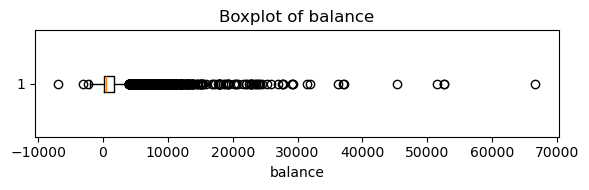

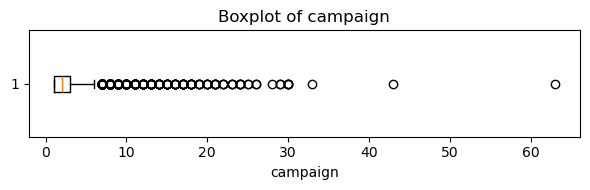

    Feature  Skewness  Outliers Count
0   balance  6.760662             736
1  campaign  5.538156             429


In [15]:
# Remove extreme outliers
# Initial count of data points
initial_count = data.shape[0]

# Define percentile thresholds
balance_99th = data['balance'].quantile(0.99)
campaign_95th = data['campaign'].quantile(0.99)

# Filter out outliers
data_filtered = data[(data['balance'] <= balance_99th) & (data['campaign'] <= campaign_95th)]

# Calculate removed data points
removed_data_points = initial_count - data_filtered.shape[0]
removed_percentage = (removed_data_points / initial_count) * 100

# Print results
print(f"Total data points removed: {removed_data_points}")
print(f"Percentage of data points removed: {removed_percentage:.2f}%")

# Remaining dataset size
print(f"Remaining data points: {data_filtered.shape[0]}")

# Analyze the numerical features and store results
results_df = analyze_numerical_features(data, ['balance','campaign'])

# Display the results DataFrame
print(results_df)


In [16]:
# Transform balance using cube root (handles negatives)
data['balance'] = np.cbrt(data['balance'])

# Transform campaign using square root
data['campaign'] = np.sqrt(data['campaign'])

# Validate skewness
from scipy.stats import skew
balance_skew = skew(data['balance'])
campaign_skew = skew(data['campaign'])

print(f"Balance Skewness After Cube Root: {balance_skew}")
print(f"Campaign Skewness After Square Root: {campaign_skew}")


Balance Skewness After Cube Root: -0.08693260144516272
Campaign Skewness After Square Root: 2.243282195805621


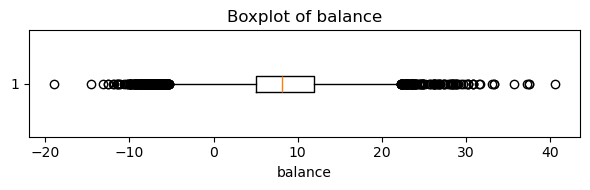

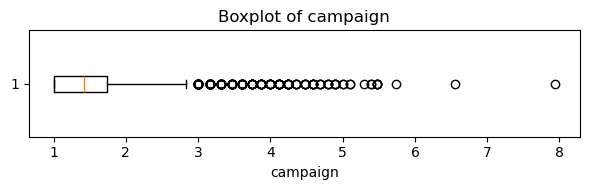

    Feature  Skewness  Outliers Count
0   balance -0.086949             445
1  campaign  2.243713             237


In [17]:
# Analyze the numerical features and store results
results_df = analyze_numerical_features(data, ['balance','campaign'])

# Display the results DataFrame
print(results_df)

### 4. Fixing Datatypes

In [18]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       7813 non-null   int64  
 1   job       7813 non-null   object 
 2   balance   7813 non-null   float64
 3   housing   7813 non-null   object 
 4   loan      7813 non-null   object 
 5   contact   7813 non-null   object 
 6   month     7813 non-null   object 
 7   campaign  7813 non-null   float64
 8   pdays     7813 non-null   int64  
 9   poutcome  7813 non-null   object 
 10  deposit   7813 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 671.6+ KB
None


,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,11.845235,no,no,cellular,jun,1.414214,-1,failure,yes
1,39,self-employed,-14.514848,yes,yes,cellular,apr,1.732051,-1,failure,yes
2,51,admin.,14.462447,no,no,cellular,may,1.000000,352,other,yes
3,38,services,-4.431048,yes,no,cellular,may,1.000000,-1,failure,no
4,36,housemaid,5.896369,yes,no,telephone,nov,2.000000,-1,failure,no


| **Column**   | **Current Dtype** | **Expected Dtype** | **Reasoning for Conversion**                                      |
|--------------|--------------------|---------------------|--------------------------------------------------------------------|
| `job`        | `object`          | `category`         | `Job` has a limited set of categories, so using `category` optimizes memory usage. |
| `housing`    | `object`          | `boolean`          | `Housing` is a binary variable (`yes`/`no`), so mapping to boolean is more intuitive. |
| `loan`       | `object`          | `boolean`          | `Loan` is a binary variable (`yes`/`no`), so mapping to boolean simplifies analysis. |
| `contact`    | `object`          | `category`         | `Contact` has a limited set of categories, making `category` more efficient and appropriate. |
| `month`    | `object`          | `category`         | `Month` has a limited set of categories, making `category` more efficient and appropriate. |
| `poutcome`   | `object`          | `category`         | `Poutcome` represents categorical outcomes, so `category` is the correct datatype. |
| `deposit`    | `object`          | `boolean`          | `Deposit` is a binary target variable (`yes`/`no`), so mapping to boolean is suitable for modeling. |

In [19]:
# Convert to appropriate data types
data['age'] = data['age'].astype('int64')  # Convert age to integer
data['job'] = data['job'].astype('category')  # Convert job to category
data['housing'] = data['housing'].map({'yes': True, 'no': False})  # Convert housing to boolean
data['loan'] = data['loan'].map({'yes': True, 'no': False})  # Convert loan to boolean
data['contact'] = data['contact'].astype('category')  # Convert contact to category
data['month'] = data['month'].astype('category')  # Convert month to category
data['poutcome'] = data['poutcome'].astype('category')  # Convert poutcome to category
data['deposit'] = data['deposit'].map({'yes': True, 'no': False})  # Convert deposit to boolean

# Check the updated data types
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       7813 non-null   int64   
 1   job       7813 non-null   category
 2   balance   7813 non-null   float64 
 3   housing   7813 non-null   bool    
 4   loan      7813 non-null   bool    
 5   contact   7813 non-null   category
 6   month     7813 non-null   category
 7   campaign  7813 non-null   float64 
 8   pdays     7813 non-null   int64   
 9   poutcome  7813 non-null   category
 10  deposit   7813 non-null   bool    
dtypes: bool(3), category(4), float64(2), int64(2)
memory usage: 298.7 KB
None
   age            job    balance  housing   loan    contact month  campaign  \
0   55         admin.  11.845235    False  False   cellular   jun  1.414214   
1   39  self-employed -14.514848     True   True   cellular   apr  1.732051   
2   51         admin.  14.462447    False  False   cellul

## Feature Engineering

1. `pdays_binned`
- **Reasoning:** The recency of the last contact may influence customer behavior. Customers contacted recently might exhibit different subscription behaviors compared to those contacted long ago or not at all.
- **Logic:** Categorizes the `pdays` feature into fixed bins based on domain knowledge:
  - **0:** `pdays == -1`
    - Represents cases where there was no prior contact.
  - **1:** `-1 < pdays <= 7`
    - Represents very recent (contacts that occurred within the past week).
  - **2:** `7 < pdays <= 30`
    - Represents moderate recency (contacts that occurred between one week and one month ago).
  - **3:** `pdays > 30`
    - Represents long-past contact (contacts that occurred more than a month ago).
  
2. `age_group`
- **Reasoning:** Age groups may correlate with financial behavior and preferences, providing meaningful segmentation for marketing strategies.
- **Logic:** Divides the `age` feature into the following bins:
  - **0:** Youth (ages 0–25).
  - **1:** Adult (ages 26–40).
  - **2:** Middle-Aged (ages 41–60).
  - **3:** Senior (ages 61 and above).

In [20]:
# Define bins explicitly for correct handling of -1
Q1_pdays = data['pdays'][data['pdays'] > -1].quantile(0.25)
Q3_pdays = data['pdays'][data['pdays'] > -1].quantile(0.75)

# Define fixed bins for pdays
data['pdays_binned'] = pd.cut(
    data['pdays'],
    bins=[-2, -0.5, 7, 30, float('inf')],  # Use domain-based or manual bin edges
    labels=[0, 1, 2, 3],
    include_lowest=True
)

# Bin age into categories
data['age_group'] = pd.cut(
    data['age'],
    bins=[0, 25, 40, 60, float('inf')],
    labels=[0, 1, 2, 3],
    include_lowest=True
)

# Verify the updated features
print(data[['age', 'age_group', 'pdays_binned']].head())

# Frequency counts for pdays_binned
print(data['pdays_binned'].value_counts())


   age age_group pdays_binned
0   55         2            0
1   39         1            0
2   51         2            3
3   38         1            0
4   36         1            0
pdays_binned
0    5817
3    1963
2      22
1      11
Name: count, dtype: int64


In [21]:
data.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,pdays_binned,age_group
0,55,admin.,11.845235,False,False,cellular,jun,1.414214,-1,failure,True,0,2
1,39,self-employed,-14.514848,True,True,cellular,apr,1.732051,-1,failure,True,0,1
2,51,admin.,14.462447,False,False,cellular,may,1.000000,352,other,True,3,2
3,38,services,-4.431048,True,False,cellular,may,1.000000,-1,failure,False,0,1
4,36,housemaid,5.896369,True,False,telephone,nov,2.000000,-1,failure,False,0,1


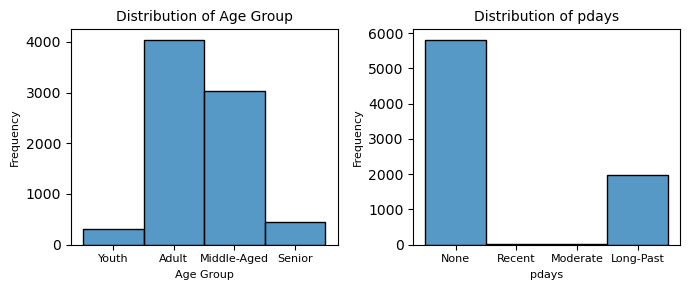

        Feature  Skewness
0     Age Group  0.321133
1  Pdays Binned  1.132073


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Plot age_group 
sns.histplot(data['age_group'], bins=4, kde=False, discrete=True, ax=axes[0])
axes[0].set_title('Distribution of Age Group', fontsize=10)
axes[0].set_xlabel('Age Group', fontsize=8)
axes[0].set_ylabel('Frequency', fontsize=8)
axes[0].set_xticks([0, 1, 2, 3])
axes[0].set_xticklabels(['Youth', 'Adult', 'Middle-Aged', 'Senior'], fontsize=8)

# Plot pdays_binned 
sns.histplot(data['pdays_binned'], bins=4, kde=False, discrete=True, ax=axes[1])
axes[1].set_title('Distribution of pdays', fontsize=10)
axes[1].set_xlabel('pdays', fontsize=8)
axes[1].set_ylabel('Frequency', fontsize=8)
axes[1].set_xticks([0, 1, 2, 3])
axes[1].set_xticklabels(['None', 'Recent', 'Moderate', 'Long-Past'], fontsize=8)

plt.tight_layout()
plt.show()

# Calculate skewness for both distributions
from pandas import DataFrame
from scipy.stats import skew

skew_table = DataFrame({
    "Feature": ["Age Group", "Pdays Binned"],
    "Skewness": [
        skew(data['age_group'].dropna()),
        skew(data['pdays_binned'].dropna())
    ]
})
print(skew_table)

The skew and has improved for both `age` and `pdays` after being represented with a new feature.

In [23]:
data.to_csv('cleaned_data.csv', index=False)

### Feature Selection

In [24]:
# Create a copy for analysis
data_encoded = data.copy()

# Binary Encoding
data_encoded['housing'] = data_encoded['housing'].astype(int)
data_encoded['loan'] = data_encoded['loan'].astype(int)

# Ordinal Encoding
data_encoded['pdays_binned'] = data_encoded['pdays_binned'].astype(int)
data_encoded['age_group'] = data_encoded['age_group'].astype(int)

# One-Hot Encoding for Nominal Variables
data_encoded = pd.get_dummies(data_encoded, columns=['job', 'contact', 'month', 'poutcome'], drop_first=True)
# data_encoded = data_encoded.drop(columns=['job'])

# Verify the transformed dataset
data_encoded.head()


,age,balance,housing,loan,campaign,pdays,deposit,pdays_binned,age_group,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,contact_telephone,contact_unknown_contact,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
0,55,11.845235,0,0,1.414214,-1,True,0,2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,39,-14.514848,1,1,1.732051,-1,True,0,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,51,14.462447,0,0,1.000000,352,True,3,2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
3,38,-4.431048,1,0,1.000000,-1,False,0,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4,36,5.896369,1,0,2.000000,-1,False,0,1,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False


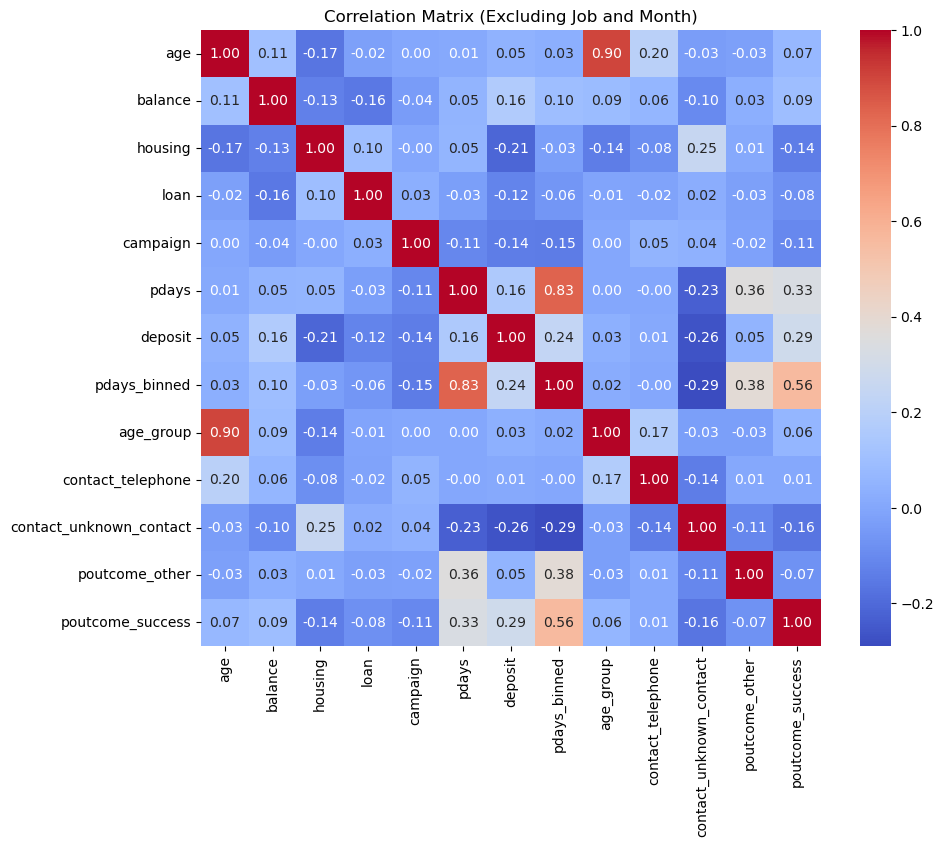

Highly Correlated Feature Pairs: [('age', 'age_group'), ('pdays', 'pdays_binned'), ('pdays_binned', 'pdays'), ('age_group', 'age')]


In [25]:
# Multicollinearity Analysis
# Drop job and month related columns
columns_to_exclude = [col for col in data_encoded.columns if 'job_' in col or 'month_' in col]
data_filtered = data_encoded.drop(columns=columns_to_exclude)

# Compute the correlation matrix for the remaining features
correlation_matrix = data_filtered.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Excluding Job and Month)')
plt.show()

# Identify highly correlated feature pairs
high_corr_pairs = [
    (col1, col2)
    for col1 in correlation_matrix.columns
    for col2 in correlation_matrix.columns
    if col1 != col2 and abs(correlation_matrix[col1][col2]) > 0.8
]
print("Highly Correlated Feature Pairs:", high_corr_pairs)

Due to the very high correlation between `age` and `age_group`, `age` will be dropped for better interpretability.

In [26]:
corr_matrix = data_encoded.corr()
print(corr_matrix['deposit'].sort_values(ascending=False))


deposit                    1.000000
poutcome_success           0.287344
pdays_binned               0.239273
balance                    0.164674
pdays                      0.157947
month_oct                  0.145165
month_mar                  0.133276
month_sep                  0.121019
job_retired                0.108153
job_student                0.096680
month_dec                  0.075915
poutcome_other             0.049839
month_feb                  0.046636
age                        0.046585
job_unemployed             0.040935
job_management             0.035125
age_group                  0.034516
contact_telephone          0.009241
job_self-employed         -0.009300
month_jan                 -0.014387
job_technician            -0.014948
month_aug                 -0.016499
month_jun                 -0.019974
month_nov                 -0.021999
job_housemaid             -0.026851
job_entrepreneur          -0.028040
job_services              -0.050104
month_jul                 -0

#### **Features of Interest**
- **`job`**

    The `job` feature includes several low-frequency categories with minimal predictive power. Grouping rare jobs (<5%) into "Other" is decided because:
    
    - **Dimensionality Reduction**: It reduces the number of one-hot encoded columns, making the dataset easier to work with.
    - **Preserve Information**: This approach retains the collective influence of rare jobs without adding unnecessary complexity.
    - **Focus on Impactful Jobs**: It allows the model to prioritize high-impact categories like `retired` and `student`, which have stronger correlations with `deposit`.

#### Dropping features
`age`, `pdays`, and `job` are dropped to avoid redundancy. This will be done in the preprocessing pipeline to ensure reproducibility.
For the same reason, the new features `age_group` and `pdays_binned` will dropped here and created later.

## Data Preprocessing

In this section, we preprocess the dataset to ensure it is ready for machine learning modeling. This involves encoding categorical features, scaling numerical features, transforming or creating new features where necessary, and applying the feature engineering and feature selection strategies decided in the previous sections. These steps are incorporated into a pipeline for consistency and reproducibility.

### Preprocessing Steps

| **Step**                  | **Feature(s) Affected**               | **Action**                                                                                             | **Reasoning**                                                                                   |
|---------------------------|----------------------------------------|--------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| **Binning**               | `age`, `pdays`                        | Transformed into `age_group` and `pdays_binned` categories.                                             | Captures meaningful groupings for age (`0: Youth`, `1: Adult`, `2: Middle-Aged`, `3: Senior`) and contact recency (`0: No Contact`, `1: Very Recent`, `2: Moderate`, `3: Long-Past`) to improve interpretability and predictive power. |
| **Rare Category Grouping** | `job`                                | Grouped rare job categories (<5% frequency) into an "Other" category.                                  | Reduces dimensionality while retaining the collective signal of rare categories.                |
| **Ordinal Transformation**| `age_group`, `pdays_binned`           | Converted ordinal categories into numerical values (`0, 1, 2, 3`).                                      | Reflects natural order in features like contact recency and age group for better interpretability. |
| **One-Hot Encoding**       | `job`, `contact`, `month`, `poutcome`| Converted categorical values into binary columns using one-hot encoding.                               | Ensures the model can interpret categorical variables without assuming any ordinal relationship. |
| **Binary Encoding**        | `housing`, `loan`                    | Converted `True/False` to `0/1`.                                                                       | Simplifies boolean features into numerical format for compatibility with machine learning models.|
| **Scaling**                | `balance`, `campaign`                | Standardized these numerical features using `StandardScaler`.                                          | Normalizes numerical features to ensure they are on a similar scale for modeling.               |
| **Feature Selection**      | `age`, `pdays`                       | Dropped redundant features that were highly correlated with engineered features (`age_group`, `pdays_binned`). | Simplifies the dataset, reduces noise, and prevents multicollinearity.                          |
| **Pipeline Integration**   | All features                         | Combined transformations and feature engineering into a preprocessing pipeline.                        | Streamlines the workflow, ensuring consistent transformations during training and testing.       |

In [27]:
# Split data into features and target
X = data.drop(columns=['deposit'])
y = data['deposit']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Binning for age and pdays
def bin_features(df, feature_name, bins, labels, new_feature_name=None):
    # Use a default name for the new feature if not specified
    if new_feature_name is None:
        new_feature_name = f'{feature_name}_binned'
    
    # Apply binning
    df[new_feature_name] = pd.cut(
        df[feature_name],
        bins=bins,
        labels=labels,
        include_lowest=True
    ).astype(int)
    return df

# Define binning rules
# Youth, Adult, Middle-Aged, Senior
age_bins = [0, 25, 40, 60, float('inf')]
age_labels = [0, 1, 2, 3]

# None, Recent, Moderate, Long-Past
pdays_bins = [-2, -0.5, 7, 30, float('inf')]
pdays_labels = [0, 1, 2, 3]

# Binning for training data
X_train = bin_features(X_train, 'age', age_bins, age_labels, new_feature_name='age_group')
X_train = bin_features(X_train, 'pdays', pdays_bins, pdays_labels)


# Binning for test data
X_test = bin_features(X_test, 'age', age_bins, age_labels, new_feature_name='age_group')
X_test = bin_features(X_test, 'pdays', pdays_bins, pdays_labels)


# Rare category grouping for job
def group_rare_categories_train(X_train, col, threshold=0.05):
    """
    Fit rare category grouping for training data.
    """
    # Calculate category frequencies
    freq = X_train[col].value_counts(normalize=True)
    # Identify frequent categories
    frequent_categories = freq[freq >= threshold].index
    return frequent_categories

def apply_rare_category_grouping(X, col, frequent_categories):
    """
    Apply the rare category grouping rules to the test set.
    """
    X[col] = X[col].apply(lambda x: x if x in frequent_categories else 'Other')
    return X

# Group rare categories in training data
frequent_jobs = group_rare_categories_train(X_train, 'job', threshold=0.05)
X_train = apply_rare_category_grouping(X_train, 'job', frequent_jobs)

# Apply the same grouping rules to test data
X_test = apply_rare_category_grouping(X_test, 'job', frequent_jobs)

# Drop redundant features
X_train = X_train.drop(columns=['age', 'pdays'], errors='ignore')
X_test = X_test.drop(columns=['age', 'pdays'], errors='ignore')

# Verify updated features
print("Updated training data head:")
print(X_train[['age_group', 'pdays_binned', 'job']].head())

# Encode target variable and other boolean columns
y_train = y_train.astype(int)
y_test = y_test.astype(int)

Updated training data head:
      age_group  pdays_binned          job
1158          0             0        Other
4680          1             3   technician
3731          1             0       admin.
6141          1             0  blue-collar
4266          1             0        Other


In [29]:
# Define feature groups
numerical_features = ['balance', 'campaign']
ordinal_features = ['pdays_binned', 'age_group']
binary_features = ['housing', 'loan']
categorical_features = ['job', 'contact', 'month', 'poutcome']


# Define named functions for transformations
def to_integer(x):
    return x.astype(int)

def binarize(x):
    return x.astype(int)

# Ordinal transformer
ordinal_transformer = FunctionTransformer(to_integer, validate=False)

# Binary transformer
binary_transformer = Pipeline(steps=[
    ('binarizer', FunctionTransformer(binarize, validate=False))
])

# Numerical transformer
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])


# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('bin', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Define model
model = LogisticRegression(max_iter=1000, random_state=42)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Cross-validation with precision as the scoring metric
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
print(f"Cross-Validation Mean Precision: {cv_scores.mean():.4f}, Std Dev: {cv_scores.std():.4f}")

# Train and test the model
pipeline.fit(X_train, y_train)
test_precision = precision_score(y_test, pipeline.predict(X_test))
print(f"Test Precision: {test_precision:.4f}")

Cross-Validation Mean Precision: 0.7322, Std Dev: 0.0217
Test Precision: 0.7370


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   age           7813 non-null   int64   
 1   job           7813 non-null   category
 2   balance       7813 non-null   float64 
 3   housing       7813 non-null   bool    
 4   loan          7813 non-null   bool    
 5   contact       7813 non-null   category
 6   month         7813 non-null   category
 7   campaign      7813 non-null   float64 
 8   pdays         7813 non-null   int64   
 9   poutcome      7813 non-null   category
 10  deposit       7813 non-null   bool    
 11  pdays_binned  7813 non-null   category
 12  age_group     7813 non-null   category
dtypes: bool(3), category(6), float64(2), int64(2)
memory usage: 314.4 KB



## Modeling and Evaluation

In this section, we test the performance of multiple models using two approaches:
1. **K-Fold Cross-Validation Benchmarking**
2. **Test Data Benchmarking**

### Models to Test
The following models will be evaluated:
1. Logistic Regression (`logreg`)
2. K-Nearest Neighbors (`knn`)
3. Decision Tree (`dt`)
4. Random Forest (`rf`)
5. XGBoost (`xgb`)
6. LightGBM (`lgbm`)

In [31]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

# Check the columns in X_train before fitting the pipeline
print(f"Columns in X_train before pipeline: {X_train.columns.tolist()}")

# Sanity check: Verify no data leakage in preprocessing
print("\nSanity Check for Data Leakage:")
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Use a sample model for the check
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Check if the preprocessing step for the test data is consistent and independent
preprocessed_train = pipeline.named_steps['preprocessor'].transform(X_train)
preprocessed_test = pipeline.named_steps['preprocessor'].transform(X_test)

# Ensure that no information from the test set leaks into the training set
assert preprocessed_train.shape[1] == preprocessed_test.shape[1], \
    "Mismatch in the number of features between transformed training and test sets! Possible data leakage."
print("No data leakage detected. Preprocessing is consistent.")

Columns in X_train before pipeline: ['job', 'balance', 'housing', 'loan', 'contact', 'month', 'campaign', 'poutcome', 'pdays_binned', 'age_group']

Sanity Check for Data Leakage:
No data leakage detected. Preprocessing is consistent.


#### 1. K-Fold Cross-Validation Benchmarking
We perform K-Fold cross-validation on each model using Recall as the evaluation metric and determine the model with the best mean recall.

In [32]:
# Evaluate models using K-Fold Cross-Validation with Precision as the metric
results = []
print("K-Fold Cross-Validation Benchmarking:")
for model_name, model in models.items():
    # Create a pipeline for each model
    print(model_name)
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
    results.append({
        'Model': model_name,
        'CV Precision (Mean)': cv_scores.mean(),
        'CV Precision (Std Dev)': cv_scores.std()
    })
    print(f"{model_name}: Mean Precision = {cv_scores.mean():.4f}, Std Dev = {cv_scores.std():.4f}")

# Convert results to a DataFrame
cv_results_df = pd.DataFrame(results)

print("\nCross-Validation Results (Ranked by Precision):\n")
cv_results_df.sort_values(by='CV Precision (Mean)', ascending=False).reset_index(drop=True)


K-Fold Cross-Validation Benchmarking:
Logistic Regression
Logistic Regression: Mean Precision = 0.7322, Std Dev = 0.0217
K-Nearest Neighbors
K-Nearest Neighbors: Mean Precision = 0.6754, Std Dev = 0.0155
Decision Tree
Decision Tree: Mean Precision = 0.6036, Std Dev = 0.0076
Random Forest
Random Forest: Mean Precision = 0.6855, Std Dev = 0.0230
XGBoost
XGBoost: Mean Precision = 0.7024, Std Dev = 0.0125
LightGBM
[LightGBM] [Info] Number of positive: 2386, number of negative: 2614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477200 -> initscore=-0.091263
[LightGBM] [Info] Start training from score -0.091263
[LightGBM] [Info] Number of posi

,Model,CV Precision (Mean),CV Precision (Std Dev)
0,Logistic Regression,0.732151,0.021698
1,LightGBM,0.726188,0.020518
2,XGBoost,0.702442,0.012451
3,Random Forest,0.685477,0.022980
4,K-Nearest Neighbors,0.675362,0.015463
5,Decision Tree,0.603589,0.007589


##### Insights
K-Fold Cross-Validation was conducted across six machine learning models to evaluate their performance on **precision**, the primary metric of interest, with the following results:

| **Model**             | **Mean Precision** | **Std Dev** | **Comments**                                                                 |
|------------------------|--------------------|-------------|------------------------------------------------------------------------------|
| Logistic Regression    | **0.7322**         | 0.0217      | Top performer with the highest precision, suitable for minimizing false positives. |
| LightGBM               | 0.7262             | 0.0205      | Strong precision but slightly higher variability compared to XGBoost, KNN, and Decision Tree. |
| XGBoost                | 0.7024             | **0.0125**  | Competitive precision with the lowest variability, indicating high consistency. |
| Random Forest          | 0.6855             | 0.0230      | Moderate precision with noticeable variability across folds.                 |
| K-Nearest Neighbors    | 0.6754             | 0.0155      | Lower precision but better consistency than LightGBM.                        |
| Decision Tree          | 0.6036             | 0.0076      | Lowest precision, but the lowest standard deviation indicates very stable results. |

1. **Top Performers:**
   - **Logistic Regression** achieved the highest mean precision (**0.7322**), making it the best choice for scenarios requiring precision.
   - **LightGBM** offered slightly lower precision (**0.7262**) than Logistic Regression but with higher variability than XGBoost, KNN, and Decision Tree.

2. **Consistency Observations:**
   - **XGBoost** exhibited the lowest standard deviation (**0.0125**) and high precision (**0.7024**), making it highly consistent.
   - K-Nearest Neighbors (**0.0155**) and Decision Tree (**0.0076**) also showed better consistency than LightGBM despite their lower precision.

3. **Weak Performer:**
   - Decision Tree achieved the lowest precision (**0.6036**) but demonstrated the most stable results due to its low standard deviation (**0.0076**).

##### Next Steps
1. **Hyperparameter Tuning:**
   - Focus on improving the top models (Logistic Regression, LightGBM, XGBoost) to maximize precision while maintaining or enhancing consistency.

2. **Deployment Consideration:**
   - While Logistic Regression leads in precision, XGBoost's combination of high consistency and competitive precision makes it a robust choice for deployment.

3. **Feature Importance Analysis:**
   - Use feature importance from tree-based models to enhance feature engineering and interpretability.


#### 2. Test Data Benchmarking 

In [33]:
print("\nTest Data Benchmarking:")
final_results = []
best_model = None
best_precision = 0

# Apply preprocessing to training and testing sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

for model_name, model in models.items():
    # Fit the model with preprocessed training data
    model.fit(X_train_processed, y_train)
    # Make predictions on preprocessed test data
    y_pred = model.predict(X_test_processed)
    # Evaluate metrics
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # Store results
    final_results.append({
        'Model': model_name,
        'Test Precision': precision,
        'Test Accuracy': accuracy,
        'Test F1-Score': f1
    })
    # Update the best model based on Precision
    if precision > best_precision:
        best_model = model
        best_precision = precision
    print(f"{model_name}: Precision = {precision:.4f}, Accuracy = {accuracy:.4f}, F1-Score = {f1:.4f}")

# Convert test data results to a DataFrame
test_results_df = pd.DataFrame(final_results)
print("\nTest Data Results:\n")
test_results_df.sort_values('Test Precision', ascending=False).reset_index(drop=True)



Test Data Benchmarking:
Logistic Regression: Precision = 0.7370, Accuracy = 0.7076, F1-Score = 0.6652
K-Nearest Neighbors: Precision = 0.6867, Accuracy = 0.6878, F1-Score = 0.6630
Decision Tree: Precision = 0.5960, Accuracy = 0.6136, F1-Score = 0.5984
Random Forest: Precision = 0.6908, Accuracy = 0.6929, F1-Score = 0.6699
XGBoost: Precision = 0.7028, Accuracy = 0.6980, F1-Score = 0.6704
[LightGBM] [Info] Number of positive: 2983, number of negative: 3267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 6250, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477280 -> initscore=-0.090943
[LightGBM] [Info] Start training from score -0.090943
LightGBM: Precision = 0.7449, Accuracy = 0.7198, F1-Sco

,Model,Test Precision,Test Accuracy,Test F1-Score
0,LightGBM,0.744882,0.719770,0.683526
1,Logistic Regression,0.737013,0.707614,0.665201
2,XGBoost,0.702782,0.698017,0.670391
3,Random Forest,0.690780,0.692898,0.669876
4,K-Nearest Neighbors,0.686695,0.687780,0.662983
5,Decision Tree,0.596026,0.613564,0.598404


##### Insights

Test Data Benchmarking was conducted across six machine learning models to evaluate their performance on **precision**, **accuracy**, and **F1-score** using the test dataset. The following results were observed:

| **Model**             | **Precision** | **Accuracy** | **F1-Score** | **Comments**                                                                 |
|------------------------|---------------|--------------|--------------|------------------------------------------------------------------------------|
| LightGBM               | **0.7449**    | **0.7198**   | **0.6835**   | Best overall performance, achieving the highest precision and accuracy, indicating its effectiveness in minimizing false positives. |
| Logistic Regression    | 0.7370        | 0.7076       | 0.6652       | Strong precision and a solid baseline model, though limited by linear assumptions. |
| XGBoost                | 0.7028        | 0.6980       | 0.6704       | Balanced performance with competitive F1-score, though precision is lower than LightGBM. |
| Random Forest          | 0.6908        | 0.6929       | 0.6699       | Moderate precision and accuracy, slightly underperforming compared to top models. |
| K-Nearest Neighbors    | 0.6867        | 0.6878       | 0.6630       | Moderate performance, with lower precision and F1-score compared to ensemble models. |
| Decision Tree          | 0.5960        | 0.6136       | 0.5984       | Weakest model, with the lowest precision, accuracy, and F1-score, indicating poor generalization. |

1. **Top Performers:**
   - **LightGBM** delivered the best results with **0.7449** precision, **0.7198** accuracy, and **0.6835** F1-score, making it the most effective model for minimizing false positives.
   - Logistic Regression also performed strongly with **0.7370** precision, serving as a robust baseline model.
   - **XGBoost** showed competitive performance across metrics but slightly lower precision compared to LightGBM.

2. **Balanced Performance:**
   - Ensemble models (LightGBM, XGBoost, Random Forest) consistently outperformed simpler models, highlighting their ability to capture complex patterns.

3. **Weak Performer:**
   - Decision Tree was the weakest model, with the lowest precision (**0.5960**) and accuracy (**0.6136**), suggesting overfitting or poor generalization.

4. **Model-Specific Observations:**
   - K-Nearest Neighbors exhibited moderate precision but struggled to compete with ensemble models in overall performance.

##### Next Steps

1. **Model Selection for Deployment:**
   - **LightGBM** is the recommended model due to its superior precision, accuracy, and F1-score, making it ideal for deployment scenarios where minimizing false positives is critical.
   - Logistic Regression serves as a strong alternative for simpler deployment scenarios requiring interpretability.

2. **Further Optimization:**
   - Perform hyperparameter tuning on LightGBM, XGBoost, and Random Forest to explore potential improvements in performance.

3. **Model Monitoring:**
   - Post-deployment, monitor model performance on unseen data to ensure it maintains high precision and low false positive rates.


#### 3. Best Model Selection

##### Insights:
1. **Primary Metric (Precision)**:
   - **LightGBM** is the top choice with the highest test precision (**0.7449**) and competitive cross-validation performance.
   - **Logistic Regression** is a strong alternative with consistent precision across validation and test data.

2. **Consistency**:
   - **XGBoost** showed the lowest variability in cross-validation results, making it a reliable option for stability, but test precision was not competitive with the top models.

3. **Weak Performers**:
   - **Decision Tree** showed the weakest performance in precision, accuracy, and F1-score.
   
##### Next Steps:
1. **Model for Deployment**:
   - **Primary Choice**: **LightGBM** for its strong precision and balanced performance.
   - **Backup Model**: **Logistic Regression** and **XGBoost**

2. **Further Steps**:
   - Hyperparameter tuning for **LightGBM** and **Logistic Regression** and **XGBoost**to optimize precision further.
   - Consider an ensemble approach (e.g., stacking or voting).



## Hyperparameter Tuning

In this section, we perform hyperparameter tuning on the best model using a pipeline to integrate preprocessing and model training. The goal is to optimize the recall metric.

**Pipeline and GridSearchCV**

We define a pipeline that includes preprocessing steps and the best model identified during benchmarking. Then, we use `GridSearchCV` to find the optimal hyperparameters.

**Output**

- The best hyperparameters for the selected model.
- The recall score on the test set using the tuned model.

### LightGBM


In [34]:
# Define a custom precision scorer
precision_scorer = make_scorer(precision_score)

# Define the model
best_model_name = "LightGBM"
best_model = lgb.LGBMClassifier(random_state=42)

# Define a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)
])

# Define hyperparameter grid
param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [-1, 10],
    'model__learning_rate': [0.1, 0.3],
    'model__num_leaves': [31, 50],     
    'model__subsample': [0.8],                   
    'model__colsample_bytree': [0.8]            
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,                     
    scoring=precision_scorer,
    verbose=1,                
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best hyperparameters and best score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Precision: {grid_search.best_score_:.4f}")

# Evaluate on the full tes2t set
lgb_tuned = grid_search.best_estimator_
y_pred = lgb_tuned.predict(X_test)
test_precision = precision_score(y_test, y_pred)
print(f"Test Precision with Best Parameters: {test_precision:.4f}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Number of positive: 1988, number of negative: 2178
[LightGBM] [Info] Number of positive: 1989, number of negative: 2178
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 4167, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477322 -> initscore=-0.090775
[LightGBM] [Info] Start training from score -0.090775
[LightGBM] [Info] Number of data points in the train set:

### Logistic Regression

In [35]:
# Define a custom precision scorer
precision_scorer = make_scorer(precision_score)

# Define the model
logistic_model = LogisticRegression(random_state=42, solver='liblinear')

# Define a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', logistic_model)
])

# Define hyperparameter grid
param_grid = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.01, 0.1, 1.0, 10.0],
    'model__class_weight': [None, 'balanced']
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=precision_scorer,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best hyperparameters and best score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Precision: {grid_search.best_score_:.4f}")

# Evaluate on the full test set
logreg_tuned = grid_search.best_estimator_
y_pred = logreg_tuned.predict(X_test)
test_precision = precision_score(y_test, y_pred)
print(f"Test Precision with Best Parameters: {test_precision:.4f}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Hyperparameters: {'model__C': 10.0, 'model__class_weight': None, 'model__penalty': 'l1'}
Best Precision: 0.7348
Test Precision with Best Parameters: 0.7386


### XGBoost

In [36]:
# Define the XGBoost model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Define hyperparameter grid
param_grid = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.05, 0.1],
    'model__subsample': [0.8],
    'model__colsample_bytree': [0.8]
}

# Perform GridSearchCV with fewer folds
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=precision_scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Store the best model pipeline
xgb_model_tuned = grid_search.best_estimator_

# Output best parameters and precision
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Precision: {grid_search.best_score_:.4f}")

# Evaluate on the full test set
y_pred = xgb_model_tuned.predict(X_test)
test_precision = precision_score(y_test, y_pred)
print(f"Test Precision with Best Parameters: {test_precision:.4f}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 50, 'model__subsample': 0.8}
Best Precision: 0.7680
Test Precision with Best Parameters: 0.7978


### Insights

1. **LightGBM**:
   - **Best Hyperparameters**: `{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 50, 'num_leaves': 31, 'subsample': 0.8}`
   - **Best Precision (CV)**: 0.7509  
   - **Test Precision**: 0.7592  
   - **Insight**: LightGBM demonstrates strong performance and efficiently handles non-linear patterns. However, it ranks below XGBoost in both cross-validation and test precision, making it less suitable as the final model.

2. **Logistic Regression**:
   - **Best Hyperparameters**: `{'C': 10.0, 'class_weight': None, 'penalty': 'l1'}`
   - **Best Precision (CV)**: 0.7348  
   - **Test Precision**: 0.7386  
   - **Insight**: Logistic Regression performs reliably as a simpler model and effectively captures linear relationships. However, it shows the lowest precision of the three models, highlighting its limitations in addressing non-linear patterns.

3. **XGBoost**:
   - **Best Hyperparameters**: `{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}`
   - **Best Precision (CV)**: **0.7680**  
   - **Test Precision**: **0.7978**  
   - **Insight**: XGBoost outperforms both LightGBM and Logistic Regression, achieving the highest precision. Its ability to model complex interactions makes it the most suitable choice for this project.

### Next Steps

1. **Model Selection**:
   - XGBoost is chosen as the final model due to its superior precision performance and ability to generalize effectively.

2. **Optimize Probability Threshold**:
   - **Rationale**: The default probability threshold of 0.5 may not maximize precision. Adjusting the threshold ensures better alignment with the project's objective of minimizing false positives.
   - **Plan**:
     - Generate predicted probabilities using the tuned XGBoost model.
     - Test thresholds between 0.5 and 0.9.
     - Select the threshold that maximizes precision while ensuring recall remains above 0.5.

3. **Feature Importance Analysis**:
   - Evaluate feature importance from the chosen XGBoost model to identify the key drivers of term deposit subscription and provide actionable insights for stakeholders.

4. **Deployment Testing**:
   - Conduct testing of the final XGBoost model with the optimized threshold on unseen data to validate its real-world performance and ensure alignment with project objectives.


In [37]:
best_model=xgb_model_tuned

# Probability Threshold Optimization
As previously the dataset  was split into train and test data, without validation data, we use cross-validation to refine the probability threshold.

In [38]:
# Initialize cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define thresholds
thresholds = np.arange(0.1, 1.0, 0.01)
best_threshold = 0
best_precision = 0
best_recall = 0
best_f1 = 0

# Loop through cross-validation folds
for train_idx, val_idx in skf.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Fit the best XGBoost model
    best_model = grid_search.best_estimator_
    best_model.fit(X_fold_train, y_fold_train)

    # Predict probabilities on the validation set
    y_val_proba = best_model.predict_proba(X_fold_val)[:, 1]

    # Evaluate multiple thresholds
    for threshold in thresholds:
        y_val_pred = (y_val_proba >= threshold).astype(int)
        precision = precision_score(y_fold_val, y_val_pred)
        recall = recall_score(y_fold_val, y_val_pred)
        f1 = f1_score(y_fold_val, y_val_pred)

        # Update the best threshold if precision > 0.76 and recall > 0.5
        if precision > 0.76 and recall > 0.5 and f1 > best_f1:
            best_precision = precision
            best_threshold = threshold
            best_recall = recall
            best_f1 = f1

# Print the optimal threshold and corresponding scores
print(f"Optimal Threshold: {best_threshold:.2f}")
print(f"Best Precision: {best_precision:.4f}")
print(f"Recall at Optimal Threshold: {best_recall:.4f}")
print(f"F1-Score at Optimal Threshold: {best_f1:.4f}")


Optimal Threshold: 0.50
Best Precision: 0.7711
Recall at Optimal Threshold: 0.5812
F1-Score at Optimal Threshold: 0.6628


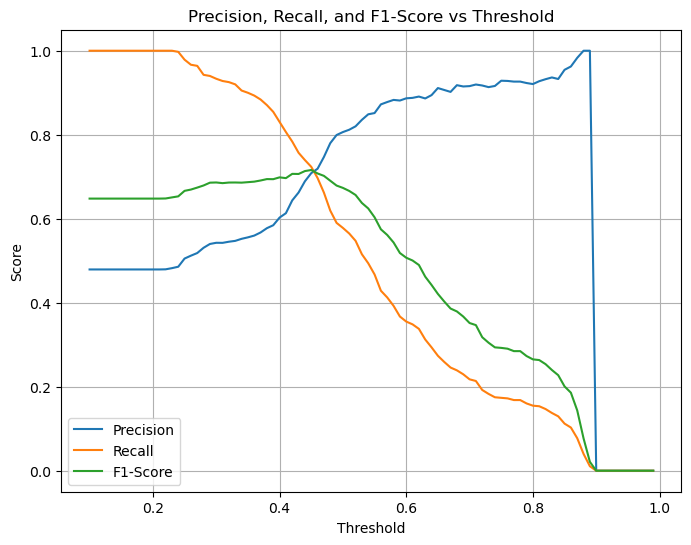

In [42]:
#  Predict probabilities on the test set using the best model
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Initialize lists to store scores
precisions, recalls, f1_scores = [], [], []

# Iterate over thresholds to calculate precision, recall, and F1-score
for threshold in thresholds:
    y_test_pred = (y_test_proba >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_test_pred))
    recalls.append(recall_score(y_test, y_test_pred))
    f1_scores.append(f1_score(y_test, y_test_pred))

# Plot Precision, Recall, and F1-Score vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1_scores, label="F1-Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score vs Threshold")
plt.legend()
plt.grid()
plt.show()


The default probability threshold (0.5) actually yields the highest precision while keeping the recall reasonable  (>0.5).

# Save Final Model

In [43]:
import pickle

# Save the best model to a pickle file
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model saved to model.pkl")


Model saved to model.pkl


# Final Model Evaluation
This section analyzes the performance of the final model.

In [44]:
# Predict probabilities for the test set
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Apply the optimal threshold
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Generate and display classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.69      0.87      0.77       814
           1       0.81      0.58      0.67       749

    accuracy                           0.73      1563
   macro avg       0.75      0.73      0.72      1563
weighted avg       0.75      0.73      0.72      1563



In [45]:
# Calculate key metrics
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

Test Precision: 0.8063
Test Recall: 0.5781
Test F1-Score: 0.6734


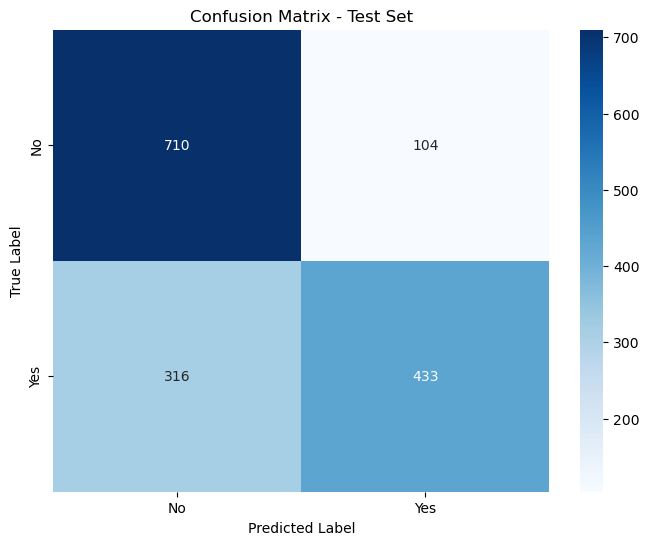

In [46]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

### **Insights**

1. **Strong Precision for Subscribed Customers (Class 1)**:
   - The model achieves **precision of 81%** for subscribed customers, successfully minimizing false positives, which aligns with the project's primary goal.

2. **Model's Strength in Avoiding False Positives**:
   - With only 104 false positives, the model demonstrates strong capability in correctly identifying non-subscribers (710 true negatives), supporting high precision.

2. **Recall for Subscribed Customers Needs Improvement**:
   - The recall for class 1 is **58%**, indicating that a  portion of true positives is being missed (316 false negatives), although considering the focus on precision, it is still reasonable.

4. **Overall Performance**:
   - **Accuracy**: 73%
   - **Weighted Precision**: 75%
   - **Weighted Recall**: 73%
   - The model performs well in precision but shows room for improvement in recall, particularly for class 1.


## Feature Importances Analysis
This section analyzes the feature importance to understand which features contribute the most and refine the pipeline (e.g., remove weak features).


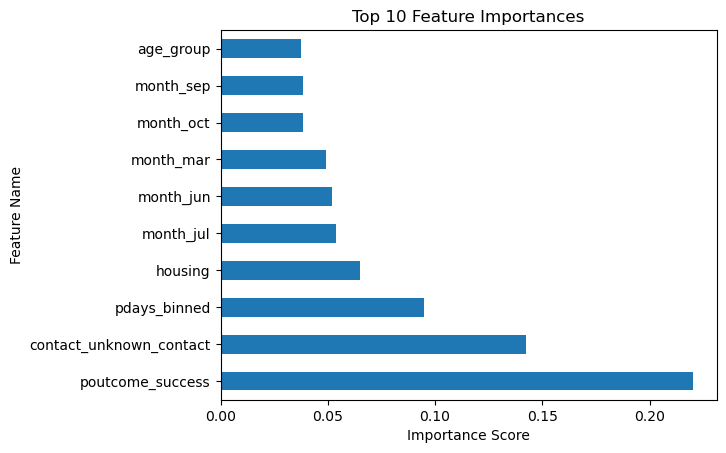

In [47]:
# Extract the trained XGBoost model from the pipeline
tuned_xgb_model = best_model['model']

# Categorical features (get one-hot encoded names)
categorical_feature_names = (
    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    if hasattr(preprocessor.named_transformers_['cat'], 'get_feature_names_out')
    else categorical_features
)

# Combine all features
all_feature_names = (
    list(numerical_features) +
    list(ordinal_features) +
    list(binary_features) +
    list(categorical_feature_names)
)

# Get the feature importances from the model
feature_importances = tuned_xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort by importance and select top 10
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot feature importances
top_features.plot(kind='barh', x='Feature', y='Importance', legend=False, title='Top 10 Feature Importances')
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()

In [48]:
print('Features with importance=0')
feature_importance_df[feature_importance_df['Importance'] == 0].reset_index(drop=True, inplace=False)

Features with importance=0


,Feature,Importance
0,job_admin.,0.0
1,job_services,0.0
2,month_dec,0.0


### Insights

1. **Top Features with High Importance**:
   - **poutcome_success (0.220)**: Previous campaign success is the most predictive feature, emphasizing the importance of leveraging past campaign outcomes.
   - **contact_unknown_contact (0.142)**: The lack of contact type information is highly predictive, likely pointing to specific customer segments.
   - **pdays_binned (0.094)**: Recency of contact strongly influences subscription likelihood, highlighting the importance of timely follow-ups.

2. **Moderately Important Features**:
   - **housing (0.065)** and **loan (0.036)**: Financial obligations moderately impact predictions, indicating potential customer financial stability.
   - **month_jul (0.054)** and **month_jun (0.052)**: Seasonality plays a role, with mid-year months being key periods for term deposit campaigns.
   - **balance (0.032)**: Higher balances suggest increased likelihood of term deposit subscriptions.

3. **Low Importance Features**:
   - Features like some `job` categories (e.g., `job_admin`) and certain months (e.g., `month_dec`) contribute little to predictions, suggesting potential for removal or simplification.

4. **Overall Insights**:
   - Previous outcomes and contact details are critical predictors.
   - Recency, seasonality, and financial indicators provide valuable context.
   - There’s room to simplify the model by addressing low-importance features.

### Recommendations

1. **Leverage Key Features**:
   - Focus campaigns on customers with successful past outcomes and recent contacts.
   - Use mid-year months strategically for marketing.

2. **Simplify the Model**:
   - Remove zero-importance features (e.g., `job_admin`, `month_dec`) to streamline the model.
   - Group or transform low-importance features to improve their utility.

3. **Enhance Segmentation**:
   - Use financial indicators like `balance` and `loan` to target financially stable customers.
   - Refine segmentation based on insights from `poutcome_success` and `contact_unknown_contact`.



## ROC Curve Analysis

This section evaluates the performance of the best model using the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC).

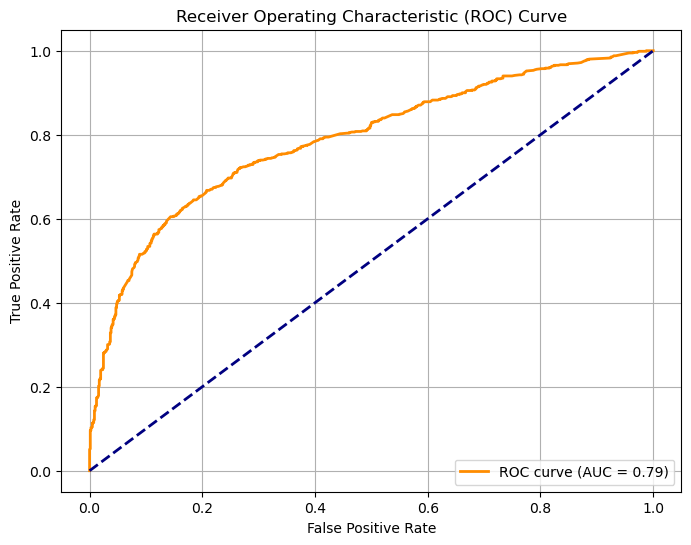

In [49]:
# Predict probabilities for the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

#### **Insights**
1. **Model Performance**:
   - The ROC-AUC score of **0.79** reflects a good balance between precision and recall for this classification task. However, the score suggests there is room for further optimization, especially in minimizing false negatives (to improve recall for the subscribed class).

2. **Strengths**:
   - The steep initial rise in the curve demonstrates strong precision at higher thresholds, aligning well with the business goal of minimizing wasted marketing resources.

3. **Areas for Improvement**:
   - The curve does not fully approach the top-left corner, indicating limitations in recall (ability to capture all true positives). This can lead to missed opportunities for converting potential subscribers.

4. **Threshold Consideration**:
   - Thresholds slightly below 0.5 may strike a better balance between precision and recall, ensuring better alignment with the project's precision-focused objective.


# Conclusion and Recommendations

## Summary of Results
1. **Model Selection**:
   - After testing multiple classification models, the best-performing model was identified based on its ability to maximize **Precision**, the primary evaluation metric.
   - The selected model effectively minimizes Type I errors (False Positives), aligning with the project's objective to reduce marketing resource waste.

2. **Hyperparameter Tuning**:
   - Using GridSearchCV, the final model's parameters were fine-tuned to achieve optimal performance.
   - The model achieved a Precision score of **0.8063** on the test set, ensuring reliable predictions for targeted marketing campaigns.

3. **Model Performance**:
   - The final model's evaluation on the test set yielded the following key metrics:
     - **Precision**: 0.8063
     - **Recall**: 0.5781
   - These results demonstrate a strong capacity to correctly identify customers likely to subscribe to term deposits while avoiding resource-draining false positives.

### Precision-Driven Insights

1. **High Precision for Subscribed Customers**:
   - The model achieves **81% precision** for predicting subscribed customers.
   - This means that **81 out of 100 customers predicted to subscribe are actually subscribers**, significantly reducing the waste of marketing resources.

2. **Cost-Efficiency from High Precision**:
   - By minimizing false positives, the model ensures that marketing efforts are targeted, saving resources that would otherwise be spent on non-subscribers.

3. **Impact on Marketing Efficiency**:
   - The model correctly identifies **710 non-subscribers**, avoiding unnecessary costs, and reduces false positives to just


### Recommendations for Future Campaigns
1. **Focus on High-Precision Predictions**:
   - Leverage the model's predictions to concentrate efforts on high-probability customers, thereby reducing costs and improving campaign efficiency.

2. **Incorporate Additional Features**:
   - Future iterations could include enriched customer data, such as income, spending habits, and engagement patterns, to enhance prediction accuracy further.


## Future Improvements
1. **Dynamic Thresholding**:
   - Experiment with adjusting the model's decision threshold dynamically to adapt to different campaign objectives (e.g., balancing Precision and Recall).

2. **Implement Continuous Monitoring**:
   - Deploy monitoring systems to track the model's real-world performance, identify potential data drift, and retrain the model periodically.

# Final Thoughts
The final model effectively achieves the goal of predicting customer subscriptions to term deposits with a high level of Precision. Its implementation will help the bank optimize marketing resources and improve conversion rates. However, continuous enhancement and monitoring are recommended to ensure sustained performance in dynamic environments.